<a href="https://colab.research.google.com/github/mnocerino23/MLB-Salary-Regressions/blob/main/ReliefPitcher_Regressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this Jupyter Notebook, I will build regression models to predict salary (in millions) for MLB relief pitchers. I will experiment with different modeling techniques such as multivariate linear, lasso, ridge, and neural network regressions

In [855]:
import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [856]:
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler

In [857]:
from sklearn import linear_model
from sklearn.linear_model import Ridge, Lasso

In [858]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

In [859]:
#read in position player stats
relievers_train = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/MLB/relievers_train.csv')
relievers_test = pd.read_csv('/content/drive/MyDrive/Data_Science_Projects/MLB/relievers_test.csv')

# Final check for null values:

In [860]:
#no null values
relievers_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 43 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     242 non-null    object 
 1   throws   242 non-null    object 
 2   age      242 non-null    int64  
 3   stints   242 non-null    int64  
 4   teamID   242 non-null    object 
 5   LG       242 non-null    object 
 6   POS1     242 non-null    object 
 7   W        242 non-null    int64  
 8   L        242 non-null    int64  
 9   CG       242 non-null    int64  
 10  ShO      242 non-null    int64  
 11  GP       242 non-null    int64  
 12  GS       242 non-null    int64  
 13  SV       242 non-null    int64  
 14  GF       242 non-null    int64  
 15  IPOuts   242 non-null    int64  
 16   IP      242 non-null    float64
 17   ERA     242 non-null    float64
 18  HA       242 non-null    int64  
 19  ER       242 non-null    int64  
 20  HRA      242 non-null    int64  
 21  BBA      242 non

In [861]:
#test data also has no nulls so we are good
relievers_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 43 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     61 non-null     object 
 1   throws   61 non-null     object 
 2   age      61 non-null     int64  
 3   stints   61 non-null     int64  
 4   teamID   61 non-null     object 
 5   LG       61 non-null     object 
 6   POS1     61 non-null     object 
 7   W        61 non-null     int64  
 8   L        61 non-null     int64  
 9   CG       61 non-null     int64  
 10  ShO      61 non-null     int64  
 11  GP       61 non-null     int64  
 12  GS       61 non-null     int64  
 13  SV       61 non-null     int64  
 14  GF       61 non-null     int64  
 15  IPOuts   61 non-null     int64  
 16   IP      61 non-null     float64
 17   ERA     61 non-null     float64
 18  HA       61 non-null     int64  
 19  ER       61 non-null     int64  
 20  HRA      61 non-null     int64  
 21  BBA      61 non-nu

In [862]:
relievers_train.head(3)

,name,throws,age,stints,teamID,LG,POS1,W,L,CG,...,WHIP,WRIP,HRBIB,RAVG,FIP,DERA,STUFF,GURU,salary,WAR
0,Jo Suarez,L,21,1,LAA,AL,Reliever,2,6,0,...,1.64,3.25,0.16,7.44,6.71,6.27,6,9,0.265576,-0.6
1,Ni Pivetta,R,26,1,PHI,NL,Reliever,4,6,1,...,1.52,2.55,0.12,6.15,5.45,5.09,28,19,0.440455,-0.1
2,Gi Gallegos,R,27,1,STL,NL,Reliever,3,2,0,...,0.81,1.43,0.08,2.31,3.04,2.85,240,108,0.522200,1.5


In [863]:
relievers_test.head(3)

,name,throws,age,stints,teamID,LG,POS1,W,L,CG,...,WHIP,WRIP,HRBIB,RAVG,FIP,DERA,STUFF,GURU,salary,WAR
0,Jo Zimmermann,R,33,1,DET,AL,Reliever,1,13,0,...,1.52,1.92,0.08,7.15,4.77,4.50,19,31,25.0000,1.2
1,Br Shaw,R,31,1,COL,NL,Reliever,3,2,0,...,1.36,2.07,0.08,5.50,5.17,5.00,14,16,8.5000,-0.2
2,Wa Suero,R,27,1,WAS,NL,Reliever,6,9,0,...,1.26,1.07,0.04,4.54,3.06,2.94,164,96,0.5625,1.4


In [864]:
#drop unncesary columns from both datasets

relievers_train.drop(columns = ['name','stints', 'LG', 'teamID'], inplace = True)
relievers_test.drop(columns = ['name','stints', 'LG', 'teamID'], inplace = True)
relievers_test.head()

,throws,age,POS1,W,L,CG,ShO,GP,GS,SV,...,WHIP,WRIP,HRBIB,RAVG,FIP,DERA,STUFF,GURU,salary,WAR
0,R,33,Reliever,1,13,0,0,23,23,0,...,1.52,1.92,0.08,7.15,4.77,4.50,19,31,25.00000,1.2
1,R,31,Reliever,3,2,0,0,70,0,1,...,1.36,2.07,0.08,5.50,5.17,5.00,14,16,8.50000,-0.2
2,R,27,Reliever,6,9,0,0,78,0,1,...,1.26,1.07,0.04,4.54,3.06,2.94,164,96,0.56250,1.4
3,R,34,Reliever,5,3,0,0,80,0,0,...,0.81,1.45,0.07,2.71,3.57,3.50,76,57,5.50000,1.4
4,R,26,Reliever,5,10,0,0,24,22,0,...,1.48,2.27,0.10,5.38,5.02,4.75,42,27,0.35808,0.2


# Reminding ourselves of the train and test data shapes (we performed an 80-20 split previously then normalized both independently)

In [865]:
print('Position Players Train:')
print('Train dataset dimensions: ', relievers_train.shape, '\n')

print('Position Players Test:')
print('Test dataset dimensions: ', relievers_test.shape, '\n')

Position Players Train:
Train dataset dimensions:  (242, 39) 

Position Players Test:
Test dataset dimensions:  (61, 39) 



# Add on feature for under rookie contract. If a player is 25 or under they are on their rookie contract else they are typically not

In [866]:
relievers_train['Rookie contract'] = ''
relievers_test['Rookie contract'] = ''

for index, row in relievers_train.iterrows():
  if relievers_train.at[index,'age'] <= 25:
    relievers_train.at[index,'Rookie contract'] = 1
  else:
    relievers_train.at[index,'Rookie contract'] = 0

for index, row in relievers_test.iterrows():
  if relievers_test.at[index,'age'] <= 25:
    relievers_test.at[index,'Rookie contract'] = 1
  else:
    relievers_test.at[index,'Rookie contract'] = 0

# One-hot encode position:

In [867]:
dummy_position = pd.get_dummies(relievers_train['POS1'])
dummy_throws = pd.get_dummies(relievers_train['throws'], prefix = 'throws')
items = [dummy_position, dummy_throws]
for item in items:
  relievers_train = pd.merge(left = relievers_train, right = item, left_index = True, right_index = True)

relievers_train.drop(columns = ['POS1', 'throws'], axis = 1, inplace = True)

In [868]:
dummy_pos = pd.get_dummies(relievers_test['POS1'])
dummy_throw = pd.get_dummies(relievers_test['throws'], prefix = 'throws')
items = [dummy_pos, dummy_throw]

for item in items:
  relievers_test = pd.merge(left = relievers_test, right = item, left_index = True, right_index = True)

relievers_test.drop(columns = ['POS1', 'throws'], axis = 1, inplace = True)

In [869]:
#display both  dataframes to ensure we have done this correctly
relievers_train.head(3)

,age,W,L,CG,ShO,GP,GS,SV,GF,IPOuts,...,FIP,DERA,STUFF,GURU,salary,WAR,Rookie contract,Reliever,throws_L,throws_R
0,21,2,6,0,0,19,15,0,0,243,...,6.71,6.27,6,9,0.265576,-0.6,1,1,1,0
1,26,4,6,1,0,30,13,1,8,281,...,5.45,5.09,28,19,0.440455,-0.1,0,1,0,1
2,27,3,2,0,0,66,0,1,10,222,...,3.04,2.85,240,108,0.522200,1.5,0,1,0,1


In [870]:
relievers_test.head(3)

,age,W,L,CG,ShO,GP,GS,SV,GF,IPOuts,...,FIP,DERA,STUFF,GURU,salary,WAR,Rookie contract,Reliever,throws_L,throws_R
0,33,1,13,0,0,23,23,0,0,336,...,4.77,4.50,19,31,25.0000,1.2,0,1,0,1
1,31,3,2,0,0,70,0,1,18,216,...,5.17,5.00,14,16,8.5000,-0.2,0,1,0,1
2,27,6,9,0,0,78,0,1,10,214,...,3.06,2.94,164,96,0.5625,1.4,0,1,0,1


In [871]:
#pitchers train has two invalid entries which are causing issues. We will drop these rows

#one value occurs in row 87
print(relievers_train.at[87, ' HR9 '])
relievers_train = relievers_train.drop(87)

#the other occurs in row 177
print(relievers_train.at[177, ' GURU '])
relievers_train = relievers_train.drop(177)
relievers_train = relievers_train.reset_index(drop = True)

 -   
 1,325 


In [872]:
relievers_test.head(10)

,age,W,L,CG,ShO,GP,GS,SV,GF,IPOuts,...,FIP,DERA,STUFF,GURU,salary,WAR,Rookie contract,Reliever,throws_L,throws_R
0,33,1,13,0,0,23,23,0,0,336,...,4.77,4.50,19,31,25.000000,1.2,0,1,0,1
1,31,3,2,0,0,70,0,1,18,216,...,5.17,5.00,14,16,8.500000,-0.2,0,1,0,1
2,27,6,9,0,0,78,0,1,10,214,...,3.06,2.94,164,96,0.562500,1.4,0,1,0,1
3,34,5,3,0,0,80,0,0,6,249,...,3.57,3.50,76,57,5.500000,1.4,0,1,0,1
4,26,5,10,0,0,24,22,0,0,351,...,5.02,4.75,42,27,0.358080,0.2,0,1,0,1
5,35,0,1,0,0,11,4,0,1,48,...,6.64,6.54,0,2,2.000000,-0.2,0,1,0,1
6,28,3,1,0,0,52,0,1,13,148,...,4.90,4.77,18,15,0.367032,-0.2,0,1,0,1
7,28,1,3,0,0,7,7,0,0,107,...,6.37,6.04,7,5,9.650000,-0.1,0,1,1,0
8,27,2,1,0,0,43,0,1,14,243,...,4.85,4.67,38,22,0.578975,0.0,0,1,0,1
9,26,3,5,0,0,14,14,0,0,219,...,3.90,3.72,243,44,0.566700,1.2,0,1,0,1


# Normalize input features using min-max normalization

In [873]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [874]:
train_target = relievers_train['salary']

train_features = relievers_train.drop(columns = ['salary'])
col = train_features.columns
train_features = scaler.fit_transform(train_features)
train_features = pd.DataFrame(data=train_features, columns=col)

In [875]:
test_target = relievers_test['salary']

test_features = relievers_test.drop(columns = ['salary'])
test_features = scaler.fit_transform(test_features)
test_features = pd.DataFrame(data=test_features, columns=col)

# Feature Selection

Vary the number of features we select to find optimal amount. I found that k = 12 features produces the best model with MAE of 3.49 million

In [876]:
top_features_ordered = []

In [877]:
best_features = SelectKBest(f_regression, k=12)
k_best_data = best_features.fit_transform(train_features, train_target)
mask = best_features.get_support()
new_features = train_features.columns[mask]
for item in new_features:
  if item not in top_features_ordered:
    top_features_ordered.append(item)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: invalid value encountered in true_divide
  correlation_coefficient /= X_norms


In [878]:
count = 1
for item in top_features_ordered:
  print(count, '. ', item)
  count += 1

1 .  age
2 .  SV
3 .  GF
4 .   ERA 
5 .  ER
6 .  HRA
7 .  RA
8 .   DOM 
9 .   RAVG 
10 .   STUFF 
11 .   GURU 
12 .  Rookie contract


In [879]:
train_selected_X = train_features[['age', ' ERA ', 'W', ' GURU ', 'WAR', 'Rookie contract', ' WHIP ']]
#train_selected_X = train_features[['age', ' ERA ',  ' GURU ', 'WAR', 'Rookie contract', ' WHIP ', 'SV']]
#train_selected_X = train_features[top_features_ordered]
train_y = train_target

test_selected_X = test_features[['age', ' ERA ', 'W', ' GURU ', 'WAR', 'Rookie contract', ' WHIP ']]
#test_selected_X = test_features[['age', ' ERA ',  ' GURU ', 'WAR', 'Rookie contract', ' WHIP ', 'SV']]
#test_selected_X = test_features[top_features_ordered]
test_y = test_target

In [880]:
print('Train Features:')
print('train_selected_X dimensions: ', train_selected_X.shape)
print('train_y dimensions:', train_y.shape, '\n')

print('Test Features:')
print('test_data_X dimensions: ', test_selected_X.shape)
print('test_data_y dimensions:', test_y.shape, '\n')

Train Features:
train_selected_X dimensions:  (240, 7)
train_y dimensions: (240,) 

Test Features:
test_data_X dimensions:  (61, 7)
test_data_y dimensions: (61,) 



# Multivariate Linear Regression

In [881]:
multivariate_regression = linear_model.LinearRegression()
multivariate_regression.fit(train_selected_X, train_y)

LinearRegression()

# Beta values (coefficients) and intercept for our multivariate linear regression:

In [882]:
multivariate_regression.coef_

array([11.41012296, -1.4949151 ,  0.03257792,  1.77539157,  1.80843274,
        1.08467951,  3.67000483])

In [883]:
multivariate_regression.intercept_

-5.098371887783367

In [884]:
y_pred = multivariate_regression.predict(test_selected_X)

In [885]:
print('Mean Squared Error: ', mean_squared_error(test_y, y_pred), '\n')
print('Mean Absolute Error: ', mean_absolute_error(test_y, y_pred), '\n')
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test_y, y_pred)))

Mean Squared Error:  31.56747278669601 

Mean Absolute Error:  2.873222746395875 

Root Mean Squared Error:  5.618493818337439


# Ridge Regression

In [886]:
ridge_regression = Ridge(alpha = 0.75)
ridge_regression.fit(train_selected_X, train_y)

Ridge(alpha=0.75)

In [887]:
ridge_regression.coef_

array([ 9.47537289, -0.92236863,  0.06027101,  1.28256058,  1.42608106,
        0.55780502,  2.40481869])

In [888]:
ridge_regression.intercept_

-3.6174087001220747

In [889]:
y_predicted = ridge_regression.predict(test_selected_X)

In [890]:
print('Mean Squared Error: ', mean_squared_error(test_y, y_predicted), '\n')
print('Mean Absolute Error: ', mean_absolute_error(test_y, y_predicted), '\n')
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test_y, y_predicted)))

Mean Squared Error:  32.52230455286639 

Mean Absolute Error:  2.847679309700265 

Root Mean Squared Error:  5.702833028667978


# Lasso Regression

In [891]:
lasso_regression = Lasso(alpha = 1.0)
lasso_regression.fit(train_selected_X, train_y)

Lasso()

In [892]:
lasso_regression.coef_

array([ 0., -0.,  0.,  0.,  0., -0., -0.])

In [893]:
lasso_regression.intercept_

2.141008925

In [894]:
y_predicted_lasso = lasso_regression.predict(test_selected_X)

In [895]:
print('Mean Squared Error: ', mean_squared_error(test_y, y_predicted_lasso), '\n')
print('Mean Absolute Error: ', mean_absolute_error(test_y, y_predicted_lasso), '\n')
print('Root Mean Squared Error: ', np.sqrt(mean_squared_error(test_y, y_predicted_lasso)))

Mean Squared Error:  43.37464035802574 

Mean Absolute Error:  3.353790669262295 

Root Mean Squared Error:  6.585942632457843


# Regression with Deep Learning

In [896]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Dropout
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns

In [897]:
tf.random.set_seed(5)

network1 = tf.keras.models.Sequential()
network1.add(tf.keras.Input(shape=(40,)))
network1.add(tf.keras.layers.Dense(15, activation='relu'))
network1.add(tf.keras.layers.Dense(15, activation='relu'))
network1.add(tf.keras.layers.Dense(1))

network1.compile(
   loss=tf.keras.losses.MeanAbsoluteError(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics='mean_absolute_error')

history1 = network1.fit(train_features, train_target, epochs=60,validation_data=(test_features,test_target))

Epoch 1/60
8/8 [==============================] - 1s 31ms/step - loss: 1.9337 - mean_absolute_error: 1.9337 - val_loss: 2.9444 - val_mean_absolute_error: 2.9444
Epoch 2/60
8/8 [==============================] - 0s 7ms/step - loss: 1.7936 - mean_absolute_error: 1.7936 - val_loss: 2.8563 - val_mean_absolute_error: 2.8563
Epoch 3/60
8/8 [==============================] - 0s 9ms/step - loss: 1.7874 - mean_absolute_error: 1.7874 - val_loss: 2.8495 - val_mean_absolute_error: 2.8495
Epoch 4/60
8/8 [==============================] - 0s 6ms/step - loss: 1.7839 - mean_absolute_error: 1.7839 - val_loss: 2.8373 - val_mean_absolute_error: 2.8373
Epoch 5/60
8/8 [==============================] - 0s 7ms/step - loss: 1.7693 - mean_absolute_error: 1.7693 - val_loss: 2.8371 - val_mean_absolute_error: 2.8371
Epoch 6/60
8/8 [==============================] - 0s 7ms/step - loss: 1.7590 - mean_absolute_error: 1.7590 - val_loss: 2.8329 - val_mean_absolute_error: 2.8329
Epoch 7/60
8/8 [=======================

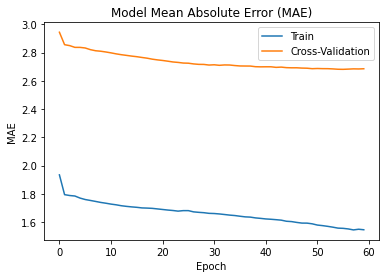

In [898]:
from matplotlib import pyplot as plt
plt.plot(history1.history['mean_absolute_error'])
plt.plot(history1.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()

In [ ]:
tf.random.set_seed(5)

network2 = tf.keras.models.Sequential()
network2.add(tf.keras.Input(shape=(40,)))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(15, activation='relu'))
network2.add(tf.keras.layers.Dense(1))

network2.compile(
   loss=tf.keras.losses.MeanAbsoluteError(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics='mean_absolute_error')

history2 = network2.fit(train_features, train_target, epochs=60,validation_data=(test_features,test_target))

Epoch 1/60
8/8 [==============================] - 1s 27ms/step - loss: 2.0977 - mean_absolute_error: 2.0977 - val_loss: 3.0814 - val_mean_absolute_error: 3.0814
Epoch 2/60
8/8 [==============================] - 0s 6ms/step - loss: 1.9418 - mean_absolute_error: 1.9418 - val_loss: 2.9177 - val_mean_absolute_error: 2.9177
Epoch 3/60
8/8 [==============================] - 0s 6ms/step - loss: 1.7959 - mean_absolute_error: 1.7959 - val_loss: 2.8638 - val_mean_absolute_error: 2.8638


In [ ]:
from matplotlib import pyplot as plt
plt.plot(history2.history['mean_absolute_error'])
plt.plot(history2.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()

In [ ]:
tf.random.set_seed(5)

network3 = tf.keras.models.Sequential()
network3.add(tf.keras.Input(shape=(8,)))
network3.add(tf.keras.layers.Dense(20, activation='relu'))
network3.add(tf.keras.layers.Dense(20, activation='relu'))
network3.add(tf.keras.layers.Dense(20, activation='relu'))
network3.add(tf.keras.layers.Dense(20, activation='relu'))
network3.add(tf.keras.layers.Dense(1))

network3.compile(
   loss=tf.keras.losses.MeanAbsoluteError(),
   optimizer=tf.keras.optimizers.Adam(),
   metrics='mean_absolute_error')

history3 = network3.fit(train_selected_X, train_target, epochs=60,validation_data=(test_selected_X,test_target))

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history3.history['mean_absolute_error'])
plt.plot(history3.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross-Validation'], loc='upper right')
plt.show()